In [2]:
# 📦 Imports
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

MAIN_DIR = "/home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/datasets/dataset_scientific_reports/"

# Cartelle
image_dir = MAIN_DIR + "data/images"
label_dir = MAIN_DIR + "data/labels"

# Classi YOLO
classes = ["pothole", "crack", "manhole"]

# Lettura delle annotazioni
annotations = []

label_files = glob.glob(os.path.join(label_dir, "*.txt"))

for label_path in tqdm(label_files):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        image_name = os.path.splitext(os.path.basename(label_path))[0]
        for line_num, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) != 9:
                print(f"❗ Skipping malformed line in {label_path} (line {line_num+1}): {line.strip()}")
                continue
            try:
                cls = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                x1 = float(parts[1])
                y1 = float(parts[2])
                x3 = float(parts[5])
                y3 = float(parts[6])
                
                width = abs(x3 - x1)
                height = abs(y3 - y1)

                annotations.append({
                    "image": image_name,
                    "class_id": cls,
                    "class_name": classes[cls],
                    "x": x_center,
                    "y": y_center,
                    "width": width,
                    "height": height,
                    "area": width * height,
                    "source": "gopro" if image_name.startswith("vlc") else "smartphone"
                })
            except Exception as e:
                print(f"⚠️ Errore nel parsing di {label_path} (line {line_num+1}): {e}")
                continue

df = pd.DataFrame(annotations)
df.head()

  0%|          | 0/2009 [00:00<?, ?it/s]

,image,class_id,class_name,x,y,width,height,area,source
0,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.284375,0.541667,0.050000,0.036111,0.001806,gopro
1,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.489063,0.561111,0.093749,0.041667,0.003906,gopro
2,vlcsnap-2025-02-19-14h13m52s026,0,pothole,0.753125,0.666667,0.125000,0.086111,0.010764,gopro
3,vlcsnap-2025-02-19-14h13m52s026,1,crack,0.632812,0.666667,0.092188,0.091666,0.008451,gopro
4,20250223_143958,1,crack,0.187500,0.244444,0.492188,0.750000,0.369141,smartphone


In [3]:
print("Numero totale di immagini:", len(df["image"].unique()))
print("Numero totale di annotazioni:", len(df))

df["class_name"].value_counts()

Numero totale di immagini: 2009
Numero totale di annotazioni: 4737


class_name
crack      2519
pothole    1261
manhole     957
Name: count, dtype: int64

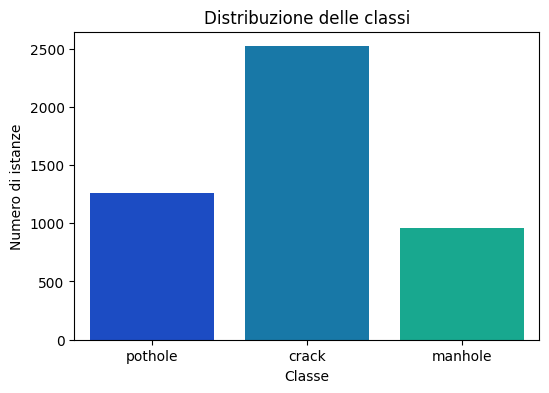

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="class_name", hue="class_name", palette="winter")
plt.title("Distribuzione delle classi")
plt.xlabel("Classe")
plt.ylabel("Numero di istanze")
plt.show()

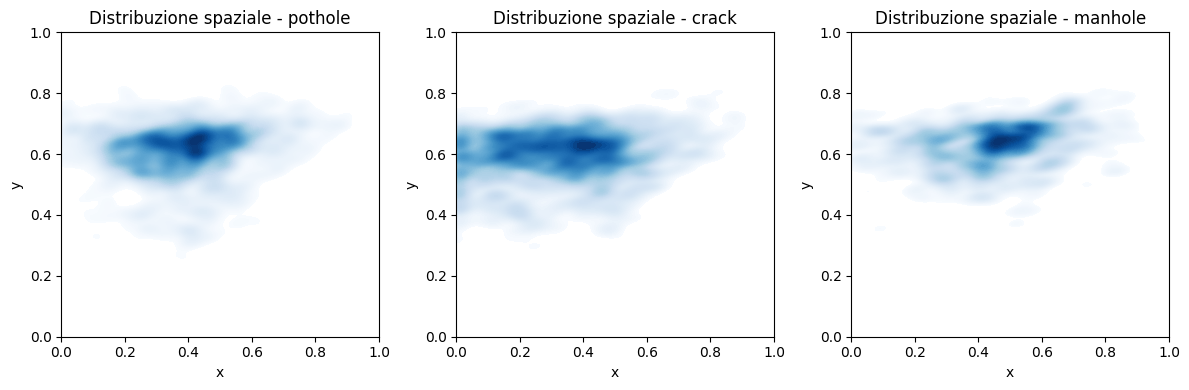

In [5]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    plt.subplot(1, 3, i+1)
    subset = df[df["class_name"] == cls]
    sns.kdeplot(x=subset["x"], y=subset["y"], fill=True, cmap="Blues", bw_adjust=0.5, levels=100, thresh=0.05)
    plt.title(f"Distribuzione spaziale - {cls}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

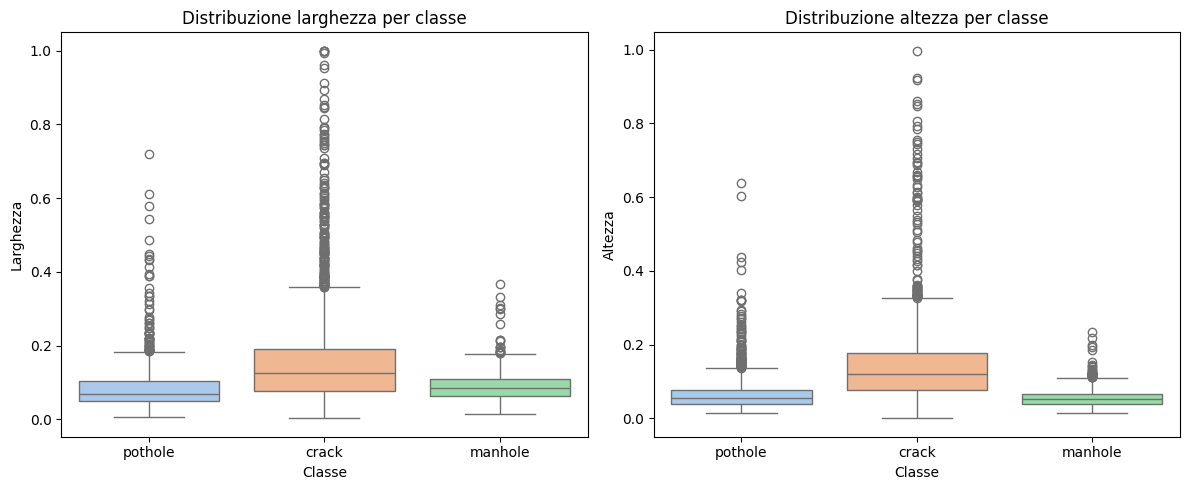

In [9]:
plt.figure(figsize=(12, 5))

# Left plot: Width distribution
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="class_name", y="width", hue="class_name", palette="pastel", legend=False)
plt.title("Distribuzione larghezza per classe")
plt.xlabel("Classe")  # Explicitly set x-axis label for clarity
plt.ylabel("Larghezza")

# Right plot: Height distribution
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x="class_name", y="height", hue="class_name", palette="pastel", legend=False)
plt.title("Distribuzione altezza per classe")
plt.xlabel("Classe")  # Explicitly set x-axis label for clarity
plt.ylabel("Altezza")

plt.tight_layout()
plt.show()

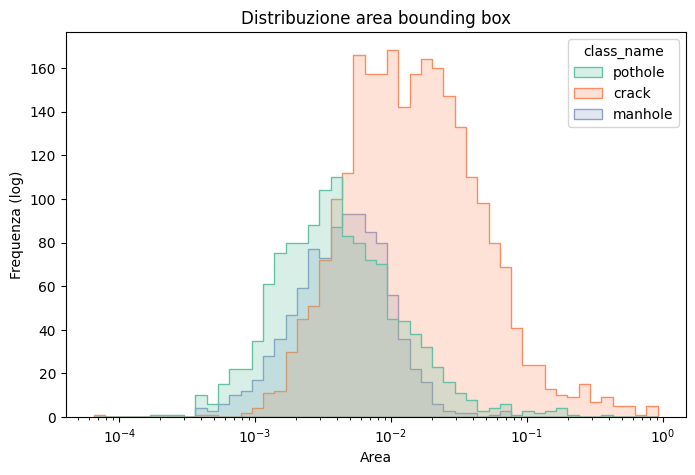

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="area", hue="class_name", bins=50, element="step", log_scale=True, palette="Set2")
plt.title("Distribuzione area bounding box")
plt.xlabel("Area")
plt.ylabel("Frequenza (log)")
plt.show()

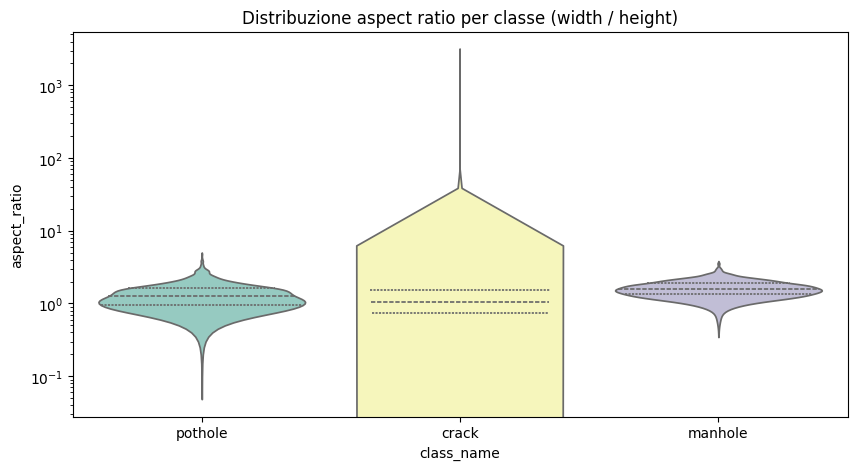

In [20]:
df["aspect_ratio"] = df["width"] / (df["height"] + 1e-6)

plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="class_name", hue="class_name", y="aspect_ratio", palette="Set3", inner="quart")
plt.title("Distribuzione aspect ratio per classe (width / height)")
plt.yscale("log")
plt.show()

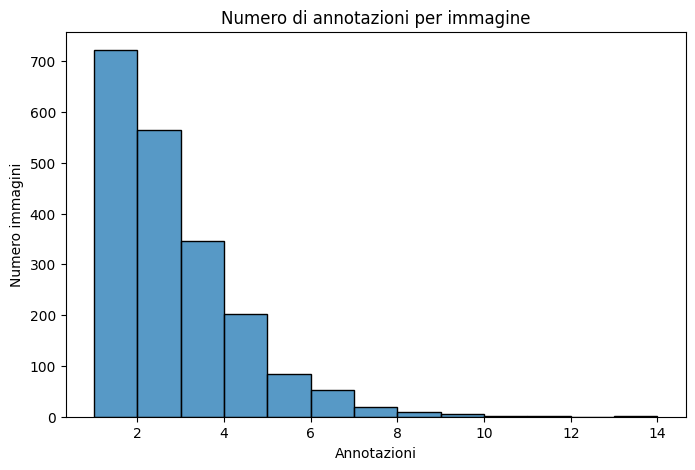

In [13]:
ann_per_image = df.groupby("image")["class_id"].count()

plt.figure(figsize=(8, 5))
sns.histplot(ann_per_image, bins=range(1, ann_per_image.max()+2), kde=False)
plt.title("Numero di annotazioni per immagine")
plt.xlabel("Annotazioni")
plt.ylabel("Numero immagini")
plt.show()

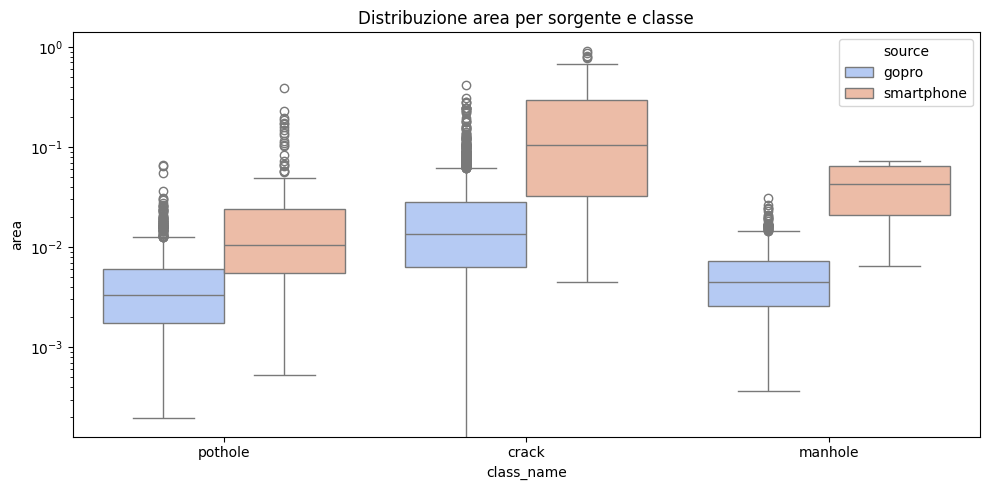

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="class_name", y="area", hue="source", palette="coolwarm")
plt.yscale("log")
plt.title("Distribuzione area per sorgente e classe")
plt.tight_layout()
plt.show()

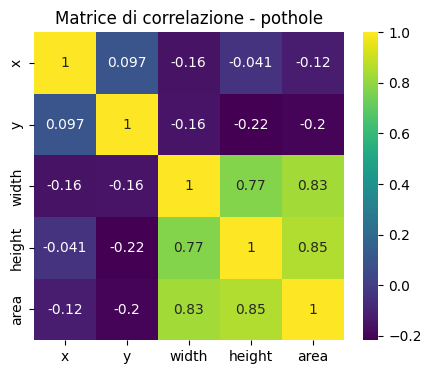

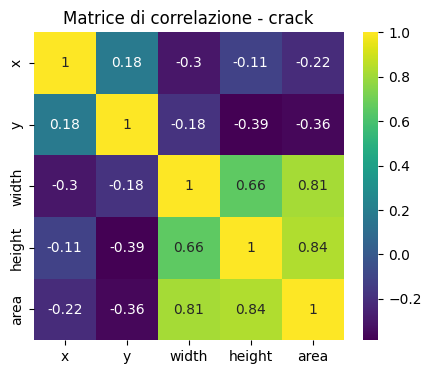

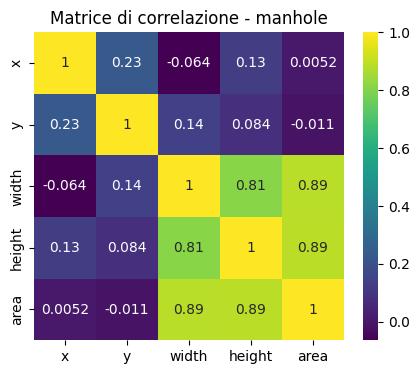

In [15]:
for cls in df["class_name"].unique():
    subset = df[df["class_name"] == cls]
    plt.figure(figsize=(5, 4))
    sns.heatmap(subset[["x", "y", "width", "height", "area"]].corr(), annot=True, cmap="viridis")
    plt.title(f"Matrice di correlazione - {cls}")
    plt.show()

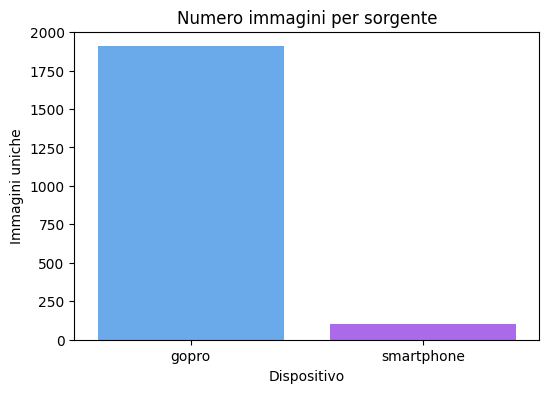

In [21]:
unique_images = df.drop_duplicates(subset="image")

plt.figure(figsize=(6, 4))
sns.countplot(data=unique_images, x="source", hue="source", palette="cool")
plt.title("Numero immagini per sorgente")
plt.ylabel("Immagini uniche")
plt.xlabel("Dispositivo")
plt.show()

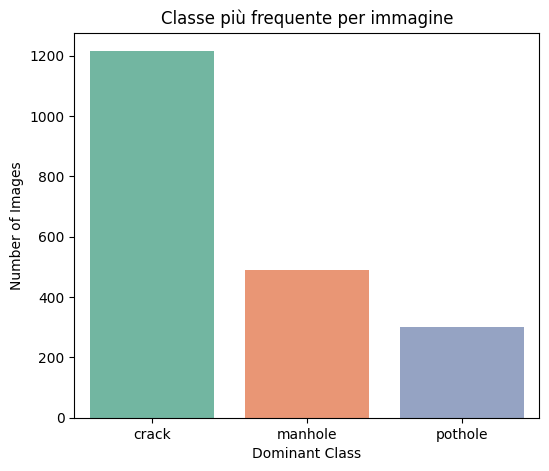

In [19]:
mode_class = df.groupby("image")["class_name"].agg(lambda x: x.mode()[0])
mode_df = mode_class.value_counts().reset_index()
mode_df.columns = ["Dominant Class", "Number of Images"]

plt.figure(figsize=(6, 5))
sns.barplot(data=mode_df, x="Dominant Class", hue='Dominant Class', y="Number of Images", palette="Set2")
plt.title("Classe più frequente per immagine")
plt.show()

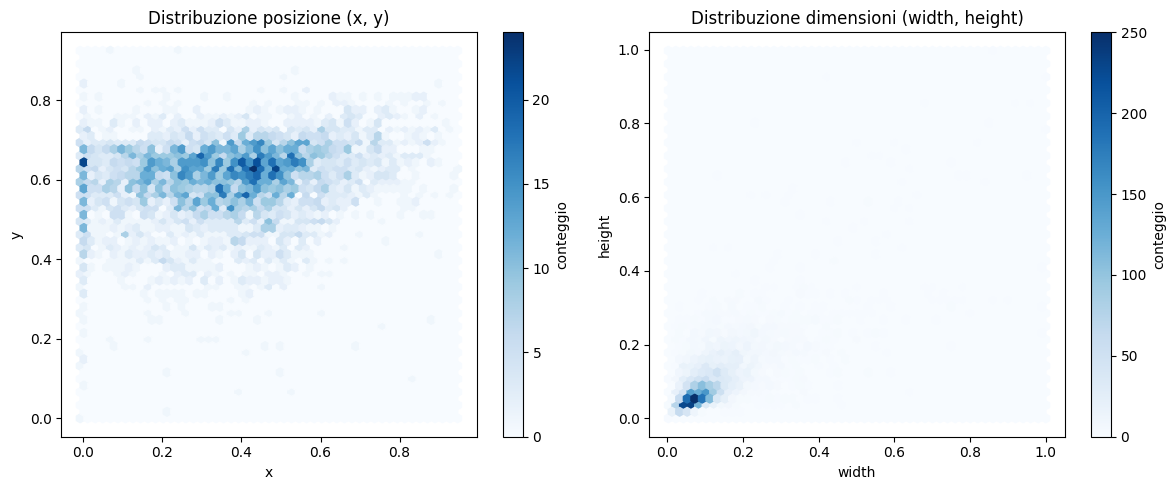

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hexbin(df["x"], df["y"], gridsize=50, cmap="Blues")
plt.title("Distribuzione posizione (x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="conteggio")

plt.subplot(1, 2, 2)
plt.hexbin(df["width"], df["height"], gridsize=50, cmap="Blues")
plt.title("Distribuzione dimensioni (width, height)")
plt.xlabel("width")
plt.ylabel("height")
plt.colorbar(label="conteggio")

plt.tight_layout()
plt.show()

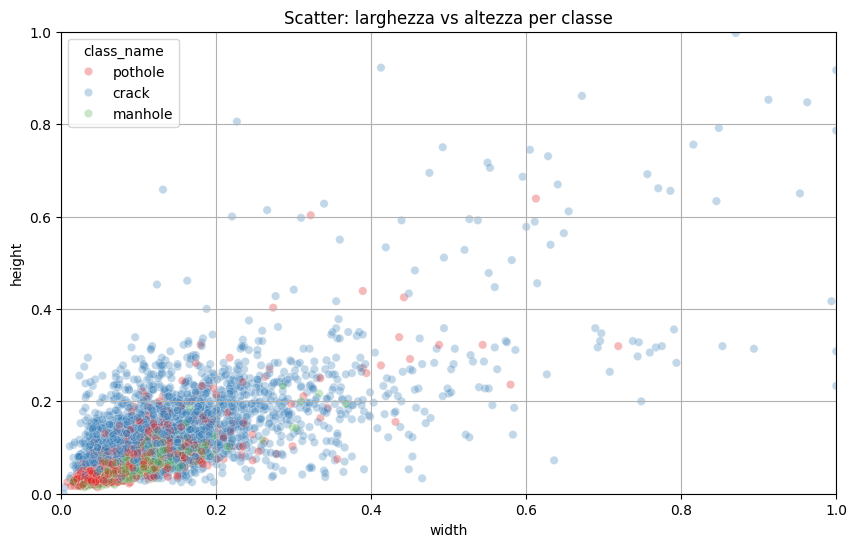

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="width", y="height", hue="class_name", alpha=0.3, palette="Set1")
plt.title("Scatter: larghezza vs altezza per classe")
plt.xlabel("width")
plt.ylabel("height")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

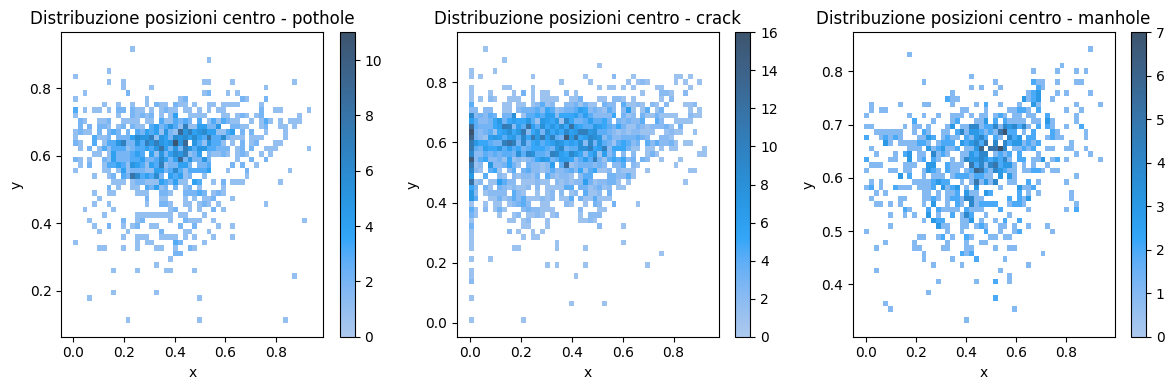

In [24]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df[df["class_name"] == cls], x="x", y="y", bins=50, cbar=True)
    plt.title(f"Distribuzione posizioni centro - {cls}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

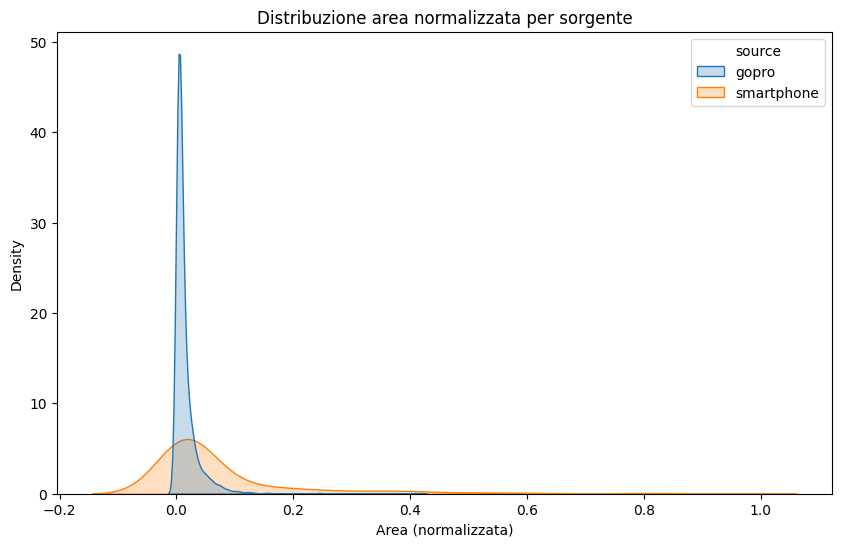

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="area", hue="source", log_scale=False, fill=True, common_norm=False, warn_singular=False)
plt.title("Distribuzione area normalizzata per sorgente")
plt.xlabel("Area (normalizzata)")
plt.show()

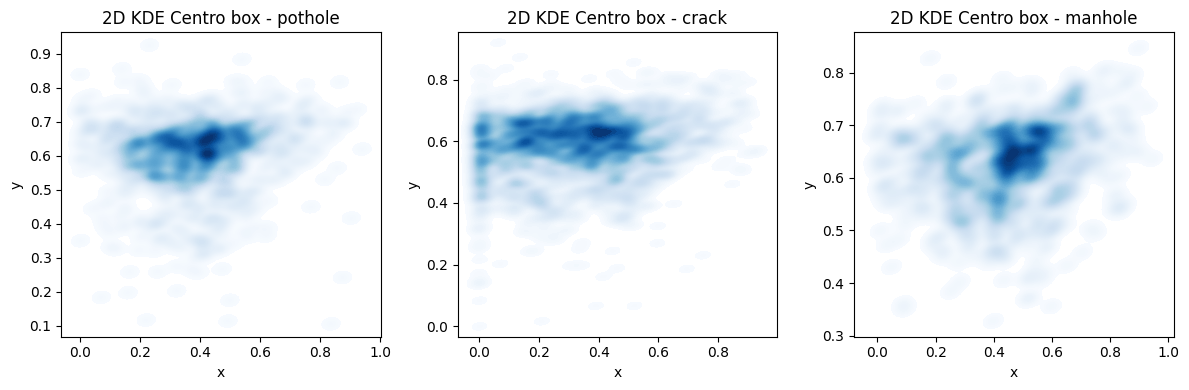

In [30]:
plt.figure(figsize=(12, 4))
for i, cls in enumerate(df["class_name"].unique()):
    subset = df[df["class_name"] == cls]
    plt.subplot(1, 3, i+1)
    sns.kdeplot(x=subset["x"], y=subset["y"], fill=True, cmap="Blues", bw_adjust=0.4, levels=100, thresh=0.01)
    plt.title(f"2D KDE Centro box - {cls}")
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()

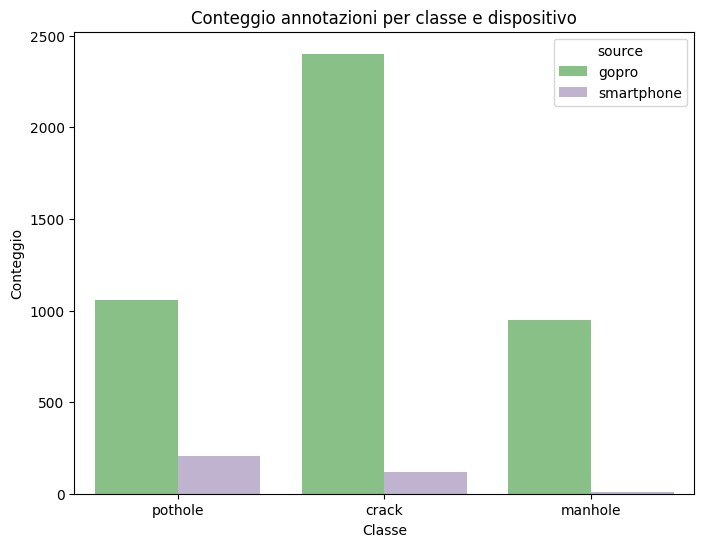

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="class_name", hue="source", palette="Accent")
plt.title("Conteggio annotazioni per classe e dispositivo")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.show()

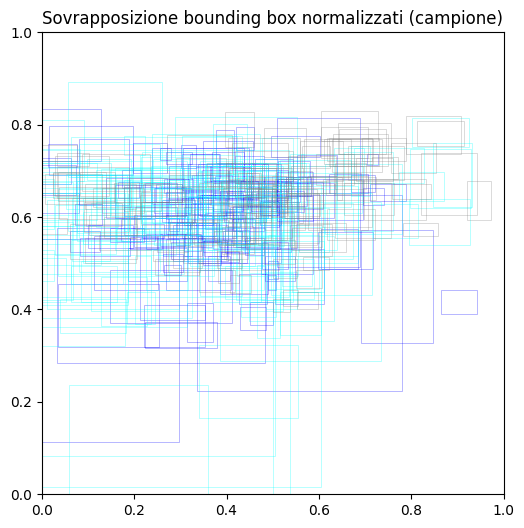

In [32]:
plt.figure(figsize=(6, 6))

colors = {"pothole": "blue", "crack": "cyan", "manhole": "gray"}
for cls in df["class_name"].unique():
    subset = df[df["class_name"] == cls]
    for _, row in subset.sample(n=min(150, len(subset)), random_state=1).iterrows():
        x0 = row["x"] - row["width"]/2
        y0 = row["y"] - row["height"]/2
        rect = plt.Rectangle((x0, y0), row["width"], row["height"],
                             edgecolor=colors[cls], facecolor='none', lw=0.5, alpha=0.4)
        plt.gca().add_patch(rect)
plt.title("Sovrapposizione bounding box normalizzati (campione)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.show()

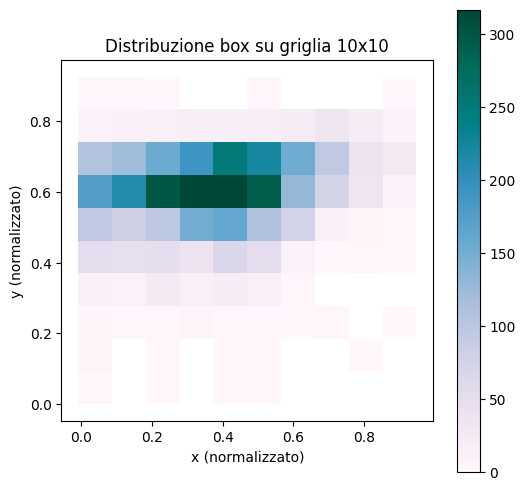

In [36]:
plt.figure(figsize=(6, 6))
sns.histplot(data=df, x="x", y="y", bins=10, pmax=0.9, cmap="PuBuGn", cbar=True)
plt.title("Distribuzione box su griglia 10x10")
plt.xlabel("x (normalizzato)")
plt.ylabel("y (normalizzato)")
plt.gca().set_aspect('equal')
plt.show()

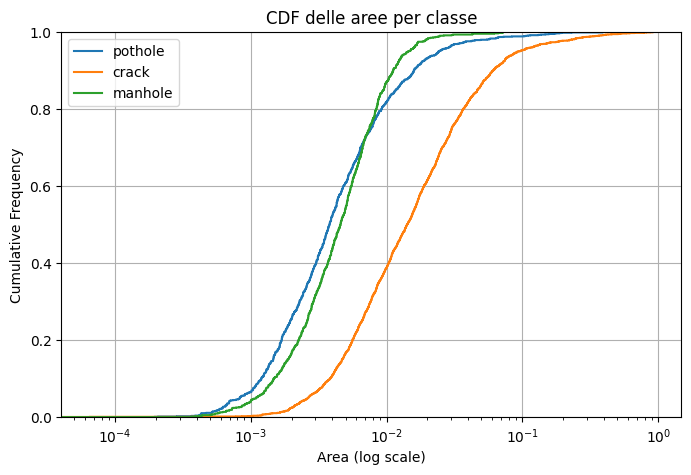

In [37]:
plt.figure(figsize=(8, 5))
for cls in df["class_name"].unique():
    sns.ecdfplot(data=df[df["class_name"] == cls], x="area", label=cls)
plt.xscale("log")
plt.title("CDF delle aree per classe")
plt.xlabel("Area (log scale)")
plt.ylabel("Cumulative Frequency")
plt.legend()
plt.grid(True)
plt.show()

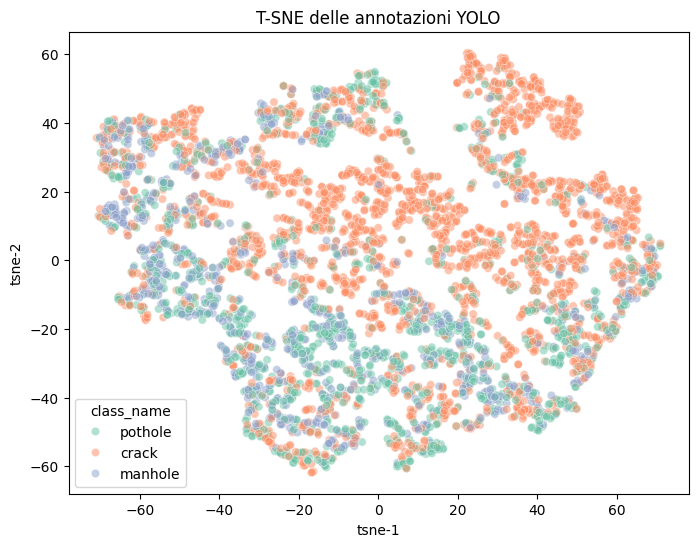

In [34]:
from sklearn.manifold import TSNE

features = df[["x", "y", "width", "height", "area"]]
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings = tsne.fit_transform(features)

df["tsne-1"] = embeddings[:, 0]
df["tsne-2"] = embeddings[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="tsne-1", y="tsne-2", hue="class_name", alpha=0.5, palette="Set2")
plt.title("T-SNE delle annotazioni YOLO")
plt.show()

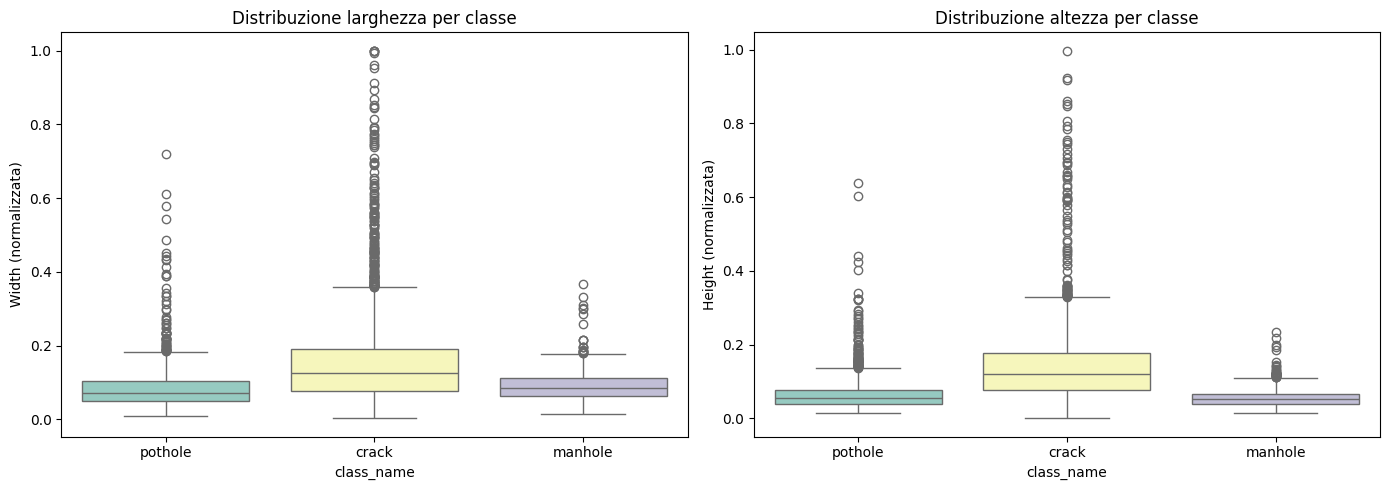

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x="class_name", hue="class_name", y="width", ax=axes[0], palette="Set3")
axes[0].set_title("Distribuzione larghezza per classe")
axes[0].set_ylabel("Width (normalizzata)")

sns.boxplot(data=df, x="class_name", y="height", hue="class_name", ax=axes[1], palette="Set3")
axes[1].set_title("Distribuzione altezza per classe")
axes[1].set_ylabel("Height (normalizzata)")

plt.tight_layout()
plt.show()

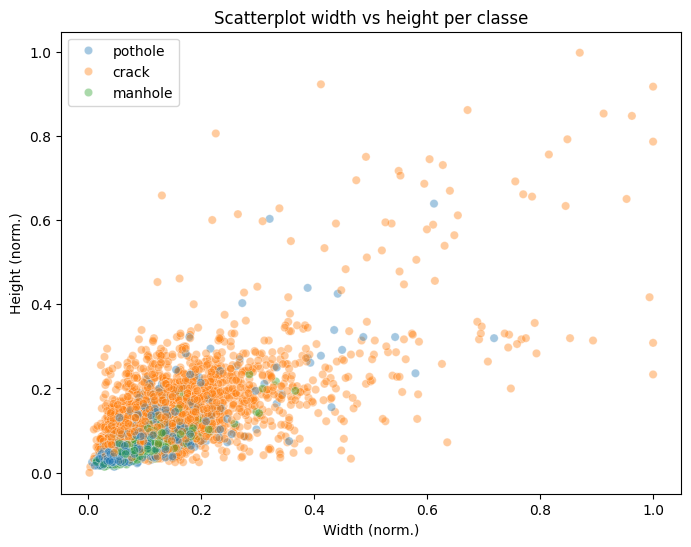

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="width", y="height", hue="class_name", alpha=0.4)
plt.title("Scatterplot width vs height per classe")
plt.xlabel("Width (norm.)")
plt.ylabel("Height (norm.)")
plt.legend()
plt.show()

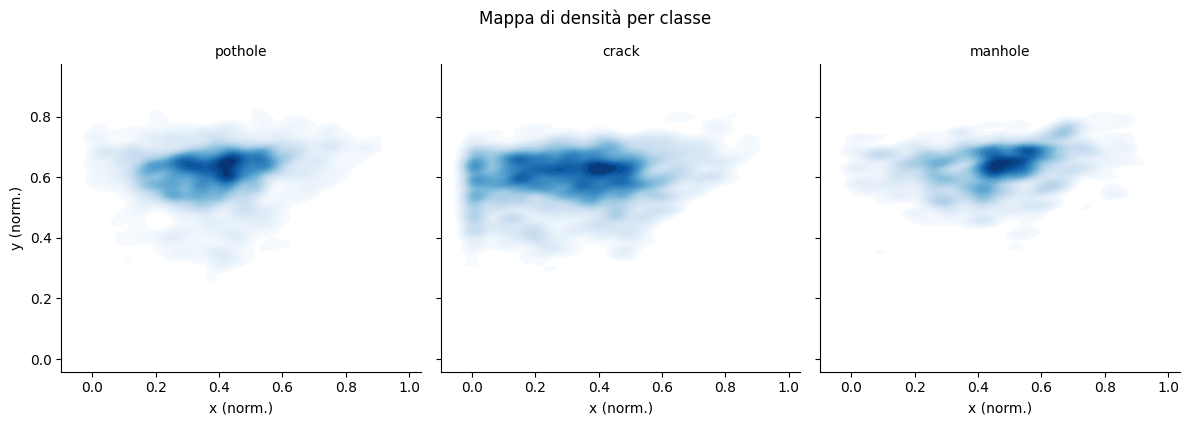

In [45]:
g = sns.FacetGrid(df, col="class_name", col_wrap=3, height=4)
g.map_dataframe(sns.kdeplot, x="x", y="y", fill=True, cmap="Blues", bw_adjust=0.5, levels=50, thresh=0.05)
g.set_axis_labels("x (norm.)", "y (norm.)")
g.set_titles("{col_name}")
g.fig.suptitle("Mappa di densità per classe", y=1.05)
plt.show()